In [1]:
#importing libraries
import pandas as pd
import numpy as np

#for handling POSIX time column
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

#model
from sklearn.tree import DecisionTreeClassifier

#used for measuring performanc of model
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


In [2]:
#lets load the data in dataframe
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Merkle_Google Store Analytics/sample_user_data.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464439 entries, 0 to 464438
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   fullVisitorId            464439 non-null  object 
 1   VisitNumber              464439 non-null  int64  
 2   Date                     464439 non-null  int64  
 3   VisitStartTime           464439 non-null  int64  
 4   bounces                  232178 non-null  float64
 5   pageviews                464387 non-null  float64
 6   timeOnSite               231612 non-null  float64
 7   totalTransactionRevenue  6308 non-null    float64
 8   transactions             6308 non-null    float64
 9   source                   464439 non-null  object 
 10  medium                   464439 non-null  object 
 11  campaign                 464439 non-null  object 
 12  deviceCategory           464439 non-null  object 
 13  operatingSystem          464439 non-null  object 
 14  mobi

In [4]:
#any customer having transaction greater than 0
#can be considered having made purchase
#we will use this to train model

train['purchased'] = train.transactions.notnull().astype(int)

In [5]:
#filling null values in bouces as 0, meaning session didn't bounced
train['bounces'].fillna(0,inplace=True)

In [6]:
#totaltransactionRevenue and transactions features are not of use since, we are predicting for new customers
#not for already logged customer.Also Visitor ID is of no use for our model. So dropping these
train.drop(['totalTransactionRevenue','transactions','fullVisitorId'],axis=1,inplace=True)

In [7]:
#since we need to make prediction only for new customers, we will filter our dataset for customers having VisitNumber as 1
train = train[train.VisitNumber == 1]
train.drop(['VisitNumber'],axis=1,inplace=True)

0    0.992997
1    0.007003
Name: purchased, dtype: float64

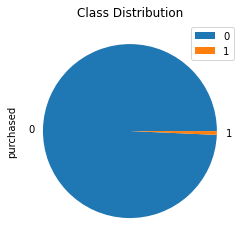

In [8]:
display(train.purchased.value_counts(normalize=True).plot.pie(title='Class Distribution',legend=True))
display(train.purchased.value_counts(normalize=True))

Data is highly imbalance. Number of people who made purchase is very Low

In [9]:
#converting datetime from time 
train['DateTime'] = train.VisitStartTime.apply(lambda tim:dt.fromtimestamp(tim).strftime('%Y-%m-%d %H'))
train.drop(['Date','VisitStartTime'],axis=1,inplace=True)

#extracting date and time from new column
train['Date'] = train.DateTime.str.slice(stop=9)
train['time'] = train.DateTime.str.slice(start=11)
train.drop(['DateTime'],axis=1,inplace=True)

In [10]:
citycross = pd.crosstab(train['city'],train['purchased'])

In [11]:
citycross.sort_values(by=1,ascending=False)

purchased,0,1
city,,
not available in demo dataset,215355,1126
New York,8835,269
Mountain View,10923,181
San Francisco,7036,157
Sunnyvale,4116,103
...,...,...
Guwahati,6,0
Gurgaon,207,0
Guatemala City,11,0


In [12]:
#there are two ways I think of using city column, either clubbing top cities as one entity in new columns and others as other
#but because most of these values are missing and can't be imputed, we will drop this column

In [13]:
train.drop(['city'],axis=1,inplace=True)

In [14]:
#relation between bounces and purchased
#Assumption is whenever session bounces, there is no purchase made
a = pd.crosstab(train.bounces,train.purchased)
a

purchased,0,1
bounces,,
0.0,167693,2474
1.0,183089,0


As expected, any bounced session, doesn't have a purchase made

In [15]:
train.drop(['bounces'],axis=1,inplace=True)

In [16]:
#lets check for source column
src = pd.crosstab(train.source,train.purchased)
src.sort_values(by=1,ascending=False)

purchased,0,1
source,,
(direct),131381,1645
google,140764,743
groups.google.com,414,15
dfa,401,14
bing,821,12
...,...,...
google.com.hk,2,0
google.com.mx,2,0
google.com.pe,1,0


In [17]:
#lets convert source column into direct and indirect (anything other than direct)
train['source_direct'] = train.source.apply(lambda src:1 if src=='(direct)' else 0)

In [18]:
train.drop(['source'],axis=1,inplace=True)

In [19]:
#let check medium column
display(train.medium.value_counts())

mdm = pd.crosstab(train.medium,train.purchased)
print('----------------------------------------------')
display(mdm.sort_values(ascending=False,by=1))

organic      138396
(none)       133024
referral      68134
affiliate      7269
cpc            5700
cpm             712
(not set)        21
Name: medium, dtype: int64

----------------------------------------------


purchased,0,1
medium,,
(none),131379,1645
organic,137717,679
cpc,5628,72
referral,68081,53
cpm,690,22
affiliate,7267,2
(not set),20,1


Medium has 21 values as not set. We will replace these with 'Organic', since it has highest count after 'none'

In [20]:
train.medium.replace(to_replace='(not set)',value='organic',inplace=True)

In [21]:
#next is campaign
camp = pd.crosstab(train.campaign,train.purchased)
camp.sort_values(ascending=False,by=1)

purchased,0,1
campaign,,
(not set),338172,2400
AW - Dynamic Search Ads Whole Site,2020,37
AW - Accessories,3293,35
Data Share Promo,7267,2
AW - Apparel,26,0
AW - Electronics,3,0
Data Share,1,0


not set values are so many that these rows cannot be even deleted. Plus most of the purchase made were for not set values, hence it seems like this column does not have much effect on the model. Hence we will not use this column in our model

In [22]:
train.deviceCategory.value_counts()

desktop    231619
mobile     106838
tablet      14799
Name: deviceCategory, dtype: int64

This column looks good. It does not have not set or missing values

In [23]:
train.mobileDeviceModel.value_counts()

not available in demo dataset    353256
Name: mobileDeviceModel, dtype: int64

Not device information is availablle in dataset. hence we will drop this column while training the model

In [24]:
train.ChannelGrouping.value_counts()

Organic Search    186337
Direct             65867
Social             54130
Referral           29970
Paid Search         8911
Affiliates          7269
Display              749
(Other)               22
Organic S              1
Name: ChannelGrouping, dtype: int64

This also looks good and can be encoded

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353256 entries, 0 to 464438
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pageviews          353253 non-null  float64
 1   timeOnSite         169875 non-null  float64
 2   medium             353256 non-null  object 
 3   campaign           353256 non-null  object 
 4   deviceCategory     353256 non-null  object 
 5   operatingSystem    353256 non-null  object 
 6   mobileDeviceModel  353256 non-null  object 
 7   ChannelGrouping    353256 non-null  object 
 8   purchased          353256 non-null  int64  
 9   Date               353256 non-null  object 
 10  time               353256 non-null  object 
 11  source_direct      353256 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 35.0+ MB


In [26]:
#lets divide time into morning,afternoon,evening,night 
def timoday(x):
  x = int(x)
  if (x >= 18 and x <= 23) or (x >= 00 and x < 6):
    return 'Night'
  elif x >= 6 and x < 12:
    return 'Morning'
  elif x >= 12 and x < 18:
    return 'Noon-Eve'

train['timeoday'] = train.time.apply(lambda a:timoday(a))
train.drop(['time'],inplace=True,axis=1)

In [27]:
timecross = pd.crosstab(train.timeoday,train.purchased)
timecross

purchased,0,1
timeoday,,
Morning,72306,125
Night,173863,1650
Noon-Eve,104613,699


Night time has highest number of purchase made

In [28]:
#imputing the missing values in Time On Site column with Mean
from sklearn.impute import SimpleImputer
impt = SimpleImputer(missing_values=np.nan,strategy='mean')
train.timeOnSite = impt.fit_transform(train[['timeOnSite']])
train.pageviews = impt.fit_transform(train[['pageviews']])

In [29]:
train.drop(['campaign','mobileDeviceModel','Date'],axis=1,inplace=True)

In [30]:
train = pd.get_dummies(train,drop_first=True)

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353256 entries, 0 to 464438
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   pageviews                       353256 non-null  float64
 1   timeOnSite                      353256 non-null  float64
 2   purchased                       353256 non-null  int64  
 3   source_direct                   353256 non-null  int64  
 4   medium_affiliate                353256 non-null  uint8  
 5   medium_cpc                      353256 non-null  uint8  
 6   medium_cpm                      353256 non-null  uint8  
 7   medium_organic                  353256 non-null  uint8  
 8   medium_referral                 353256 non-null  uint8  
 9   deviceCategory_mobile           353256 non-null  uint8  
 10  deviceCategory_tablet           353256 non-null  uint8  
 11  operatingSystem_Android         353256 non-null  uint8  
 12  operatingSystem_

In [32]:
from sklearn.model_selection import train_test_split
y = train['purchased']
x = train.drop(['purchased'],axis=1)
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.3)

In [33]:
#we will use Kfold validation to validate the model
f1 = np.array([])
acc = np.array([])
prec = np.array([])
recal = np.array([])

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

for train_index,test_index in skf.split(x,y):
  x_train,x_test = x.iloc[train_index],x.iloc[test_index]
  y_train,y_test = y.iloc[train_index],y.iloc[test_index]
  model = DecisionTreeClassifier(random_state=42)
  model.fit(x_train,y_train)
  pred = model.predict(x_test)
  #print('{} iteration for decision tree has \n f1 score of {} \n accuracy of {} \n precision of {} \n recall of {}'.format(i,f1_score(y_test,pred),accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred)))
  f1 = np.append(f1,f1_score(y_test,pred))
  acc = np.append(acc,accuracy_score(y_test,pred))
  prec = np.append(prec,precision_score(y_test,pred))
  recal = np.append(recal,recall_score(y_test,pred))
  #print(f1_score(y_test,pred))
print('Mean of  \n F1 Score is {} \n Accuracy Score is {} \n Precision Score is {} \n Recall Score is {}'.format(np.mean(f1),np.mean(acc),np.mean(prec),np.mean(recal)))

Mean of  
 F1 Score is 0.22354208058102804 
 Accuracy Score is 0.988792828493764 
 Precision Score is 0.21732126253774667 
 Recall Score is 0.2303856377540588


Accuracy is very high but f1 score and other metrics are very low.

In [34]:
#lets try parameter tuning using Gridsearch
parameters = {"criterion":["gini","entropy"],
              "splitter":["best","random"],
              "class_weight":[{1:50000,0:1},{1:100,0:1},{1:10000,0:1},{1:350782,0:2474}],
              "max_features":['auto','log2','sqrt',None]}

In [35]:
from sklearn.model_selection import GridSearchCV
tuning_model = GridSearchCV(model,param_grid=parameters,verbose=0,scoring='f1',cv=3)
tuning_model.fit(x,y)

#best hyperparameters
tuning_model.best_params_

{'class_weight': {0: 2474, 1: 350782},
 'criterion': 'entropy',
 'max_features': 'auto',
 'splitter': 'best'}

In [36]:
#we will use Kfold validation to validate the model

f1 = np.array([])
acc = np.array([])
prec = np.array([])
recal = np.array([])

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

for train_index,test_index in skf.split(x,y):
  x_train,x_test = x.iloc[train_index],x.iloc[test_index]
  y_train,y_test = y.iloc[train_index],y.iloc[test_index]
  model = DecisionTreeClassifier(random_state=42,criterion='entropy',max_features='auto',splitter='best',class_weight={0: 2474, 1: 350782})
  model.fit(x_train,y_train)
  pred = model.predict(x_test)
  #print('{} iteration for decision tree has \n f1 score of {} \n accuracy of {} \n precision of {} \n recall of {}'.format(i,f1_score(y_test,pred),accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred)))
  f1 = np.append(f1,f1_score(y_test,pred))
  acc = np.append(acc,accuracy_score(y_test,pred))
  prec = np.append(prec,precision_score(y_test,pred))
  recal = np.append(recal,recall_score(y_test,pred))
  #print(f1_score(y_test,pred))
print('Mean of  \n F1 Score is {} \n Accuracy Score is {} \n Precision Score is {} \n Recall Score is {}'.format(np.mean(f1),np.mean(acc),np.mean(prec),np.mean(recal)))

Mean of  
 F1 Score is 0.23080804504532915 
 Accuracy Score is 0.989435423185111 
 Precision Score is 0.23554679552398977 
 Recall Score is 0.22634850529587372


These scores are slightly better than what we had previously

Since our goal is to get rightly target more of those who are going to make purchase, lets try synthetic over sampling of set as well

In [37]:
from imblearn.over_sampling import SMOTE
oversampler = SMOTE()
x,y = oversampler.fit_resample(x,y)

#we will use Kfold validation to validate the model

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
f1 = np.array([])
acc = np.array([])
prec = np.array([])
recal = np.array([])

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

for train_index,test_index in skf.split(x,y):
  x_train,x_test = x[train_index],x[test_index]
  y_train,y_test = y[train_index],y[test_index]
  model = DecisionTreeClassifier(random_state=42,criterion='entropy',max_features='auto',splitter='best',class_weight={0: 2474, 1: 350782}) #with Class Weights
  model.fit(x_train,y_train)
  pred = model.predict(x_test)
  #print('{} iteration for decision tree has \n f1 score of {} \n accuracy of {} \n precision of {} \n recall of {}'.format(i,f1_score(y_test,pred),accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred)))
  f1 = np.append(f1,f1_score(y_test,pred))
  acc = np.append(acc,accuracy_score(y_test,pred))
  prec = np.append(prec,precision_score(y_test,pred))
  recal = np.append(recal,recall_score(y_test,pred))
  #print(f1_score(y_test,pred))
print('Mean of  \n F1 Score is {} \n Accuracy Score is {} \n Precision Score is {} \n Recall Score is {}'.format(np.mean(f1),np.mean(acc),np.mean(prec),np.mean(recal)))

Mean of  
 F1 Score is 0.9944351683002861 
 Accuracy Score is 0.9944352901804345 
 Precision Score is 0.9944579477982742 
 Recall Score is 0.9944124844317411


In [38]:
#we will use Kfold validation to validate the model

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
f1 = np.array([])
acc = np.array([])
prec = np.array([])
recal = np.array([])

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

for train_index,test_index in skf.split(x,y):
  x_train,x_test = x[train_index],x[test_index]
  y_train,y_test = y[train_index],y[test_index]
  model = DecisionTreeClassifier(random_state=42,criterion='entropy',max_features='auto',splitter='best') #without Class Weights
  model.fit(x_train,y_train)
  pred = model.predict(x_test)
  #print('{} iteration for decision tree has \n f1 score of {} \n accuracy of {} \n precision of {} \n recall of {}'.format(i,f1_score(y_test,pred),accuracy_score(y_test,pred),precision_score(y_test,pred),recall_score(y_test,pred)))
  f1 = np.append(f1,f1_score(y_test,pred))
  acc = np.append(acc,accuracy_score(y_test,pred))
  prec = np.append(prec,precision_score(y_test,pred))
  recal = np.append(recal,recall_score(y_test,pred))
  #print(f1_score(y_test,pred))
print('Mean of  \n F1 Score is {} \n Accuracy Score is {} \n Precision Score is {} \n Recall Score is {}'.format(np.mean(f1),np.mean(acc),np.mean(prec),np.mean(recal)))

Mean of  
 F1 Score is 0.9943422413333808 
 Accuracy Score is 0.9943412145581894 
 Precision Score is 0.9941553598228603 
 Recall Score is 0.9945293650608791


***So if we Oversample over minority class, and bring in all the parameters, we tends to get high accuracy, percision and F1 Score. Hence we will create our Decision tree model on oversampled set and using the same parameters***

In [39]:
model = DecisionTreeClassifier(random_state=42,criterion='entropy',max_features='auto',splitter='best',class_weight={0: 2474, 1: 350782})
model.fit(x,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 2474, 1: 350782},
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')

In [ ]:
model.predict() #can be used to make prediction of any new customers on site